In [1]:
import gmsh
import subprocess
import math
import sys,os, shutil
import pandas
import numpy as np
gmsh.__file__
import matplotlib.pyplot as plt

In [2]:
# GMSH meshing
# export files for mesh and image of mesh/model
def save_mesh(context, meshpath, gifpath):  
    if  not os.path.isdir(context['project_dir']):
        print(f"Creating project dir: `{context['project_dir']}`")
        print( os.mkdir(context['project_dir']))
        
    if gifpath:
        gmsh.fltk.initialize()
        gmsh.write(os.path.join(context['project_dir'], gifpath))
        gmsh.fltk.finalize()        
    if meshpath:
        gmsh.option.setNumber('Mesh.SaveAll', 1)
        gmsh.write(os.path.join(context['project_dir'],meshpath))

# SU2 Case setup
# build a config for a Solver to run a case:        
def save_config(context, base_config_path='base.cfg'):
    config_path=os.path.join(context['project_dir'], f"{context['project_name']}.cfg")
    project_config=open(base_config_path).read().format(**context)
    print(f"writing CNF: '{config_path}'")
    with open(config_path,'w') as f:
        f.write(project_config)

# build a case - geometry, mesh, physical context, solver params. Maybe should be factored a little...
def create_sim(project_name, fuselage_rad=gmsh.pi/16.0, wing_rad=gmsh.pi/4.0, wedge_rad=gmsh.pi/16.0, 
               meshing=True, 
                xshift=0, camX=30.0,camY=60.0,camZ=0.0,camZoom=5.0,
                meshpath=None, gifpath=None, popup=True, angle_of_attack=0.0, meshsize_large=5.0,
              clip_wing=True, case_index=None, case_name=None, project_dir=None):

    # Setup Geometry 
    p_height = 11.0
    p_width = 8.5
    p_thickness = 0.2
    
    gmsh.initialize()
    gmsh.model.add(project_name)
    gmsh.option.setNumber("General.Trackball", 0)

    gmsh.option.setNumber("General.RotationX", camX) #187.3729455233209))
    gmsh.option.setNumber("General.RotationY", camY) #276.7547707531851))
    gmsh.option.setNumber("General.RotationZ", camZ) # 296.8673379509896))
    gmsh.option.setNumber("General.ScaleX", camZoom) 
    gmsh.option.setNumber("General.ScaleY", camZoom) 
    gmsh.option.setNumber("General.ScaleZ", camZoom) 

    # Actual model!
    phi = fuselage_rad # wedge_radians #gmsh.pi/16.0

    # x coordinate of wing fold
    fuselage_height = p_height* math.sin(phi)

    # right vertical wedge; build then tilt; RF Right Fuselage [a,b,c]
    rfb = [0.0, 0.0, 0.0] # back corner of fuselage; origin
    rfa = [0.0, fuselage_height, 0.0]
    rfc = [p_height, 0.0, 0.0] # tip of front
    
    # right wing, vertical
    rwb = rfa.copy()
    rwa = rwb.copy()
    rwa[1] += p_width/2.0 - fuselage_height

    rwc = rfc.copy()

    rf=make_triangle(rfa, rfb, rfc, 0.2)
    rw=make_triangle(rwa, rwb, rwc, 0.2)    
    
    # trim wing
    if clip_wing:
        cutbox=gmsh.model.occ.addBox(
           rwa[0], p_width/2.0-rfa[1], rfa[2]-5*p_thickness,
           p_height,   p_width, 10*p_thickness )   
        rw, v1b = gmsh.model.occ.cut(rw,[(3,cutbox)], removeTool=True)

    #rotate wing along top edge of fuselage
    gmsh.model.occ.rotate(rw,rfa[0],rfa[1],rfa[2],rfc[0]-rfa[0],rfc[1]-rfa[1],rfc[2]-rfa[2],wing_rad)
    
    # merge fuselage and wing
    rh, rhb = gmsh.model.occ.fuse(rf,rw)
    
    #rotate halfplane along bottom of plane
    gmsh.model.occ.rotate(rh,rfb[0],rfb[1],rfb[2],rfc[0]-rfb[0],rfc[1]-rfb[1],rfc[2]-rfb[2],wedge_rad)
        
    lf=make_triangle(rfa, rfb, rfc, 0.2)
    lw=make_triangle(rwa, rwb, rwc, 0.2)
    
    if clip_wing:
        cutbox2=gmsh.model.occ.addBox(
            rwa[0], p_width/2.0-rfa[1], rfa[2]-5*p_thickness,
           p_height,   p_width, 10.0*p_thickness )   
        lw, v1b = gmsh.model.occ.cut(lw,[(3,cutbox2)])
    
    #rotate wing along top edge of fuselage
    gmsh.model.occ.rotate(lw,rfa[0],rfa[1],rfa[2],rfc[0]-rfa[0],rfc[1]-rfa[1],rfc[2]-rfa[2],-wing_rad)
    
    # merge fuselage and wing
    #print(f"Fuselage: {rf} Wing: {rw}")
    lh, lhb = gmsh.model.occ.fuse(lf,lw)
    
    #rotate halfplane along bottom of plane
    gmsh.model.occ.rotate(lh,rfb[0],rfb[1],rfb[2],rfc[0]-rfb[0],rfc[1]-rfb[1],rfc[2]-rfb[2],-wedge_rad)
    
    p1, p1b =  gmsh.model.occ.fuse(lh,rh)
    
    # build skybox
    b1=gmsh.model.occ.addBox(-4*p_height,-4*p_width,-4*p_width, 8*p_height, 8*p_width, 8*p_width)

    # create negative volume around plane model
    v1, v1b = gmsh.model.occ.cut([(3,b1)],p1)

    gmsh.model.occ.synchronize()

    if meshing:
        lcar_big = meshsize_large
        lcar2 = 1.0
        lcar3 = .055

        # Assign a mesh size to all the points:
        gmsh.model.mesh.setSize(gmsh.model.getEntities(0), lcar_big)
        #gmsh.model.mesh.setSize([(2,s) for s in wall_surfaces], lcar1)
        gmsh.model.mesh.generate(3)

    plane_surfaces = []
    wall_surfaces = []

    surfaces = gmsh.model.occ.getEntities(dim=2)
    for s in surfaces:
        com = gmsh.model.occ.getCenterOfMass(s[0], s[1])
        if np.allclose(com, [p_height/2.0, 0, 0],atol=6.0):
            plane_surfaces.append(s[1])
        else:
            wall_surfaces.append(s[1])

    # Set up physical groups for boundaries and markers in Simulation        
    wall_marker = 1
    plane_marker = 2
    gmsh.model.addPhysicalGroup(2, wall_surfaces, wall_marker)
    gmsh.model.setPhysicalName(2, wall_marker, "Walls")
    gmsh.model.addPhysicalGroup(2, plane_surfaces, plane_marker)
    gmsh.model.setPhysicalName(2, plane_marker, "Plane")

    save_mesh(locals(),meshpath, gifpath)
    save_config(context=locals())
    if popup:
        gmsh.fltk.run()
    gmsh.finalize()

# SU2 Geometry
# Build a triangular volume    
def make_triangle(rp0,rp1,rp2,d, mesh_size=1.0, recenter=True):
    #print(f"making TRI: {rp0} | {rp1} | {rp2}...")
    p1 = gmsh.model.occ.addPoint(rp0[0], rp0[1], rp0[2], mesh_size)
    p2 = gmsh.model.occ.addPoint(rp1[0], rp1[1], rp1[2], mesh_size)
    p3 = gmsh.model.occ.addPoint(rp2[0], rp2[1], rp2[2], mesh_size)
    l1 = gmsh.model.occ.addLine(p1,p2)
    l2 = gmsh.model.occ.addLine(p2,p3)
    l3 = gmsh.model.occ.addLine(p3,p1)
    c1 = gmsh.model.occ.addCurveLoop([l1,l2,l3])
    s1 = gmsh.model.occ.addPlaneSurface([c1])
    v1 = gmsh.model.occ.extrude([(2,s1)], 0.0,0.0,d)
    newVolTag = [x for x in v1 if x[0]==3]
    if recenter:
         gmsh.model.occ.translate(newVolTag, 0, 0, -d/2.0)
    #
    return newVolTag

# SU2 Execution
def run_conf(conf, i, meshing, run, as_row=True, popup=False, extract=['lift', 'drag']):
    case_name=f"{project_name}-{i:0>3}"
    #i = conf['case_index']
    #meshsize = conf['mesh_size']
    meshpath=f"{case_name}.su2"
    gifpath=f"{project_name}-{i:0>3}.jpg"
    create_sim(case_name, meshing=meshing, 
        gifpath=gifpath, 
        meshpath=meshpath if meshing else None,
        popup=popup, #meshsize_large=meshsize,
        **conf)
    if run:
        subprocess.run(["/Users/scot/Projects/SU2/bin/SU2_CFD", f"{conf['project_dir']}/{case_name}.cfg"]) 
    run_dict =  {'meshpath': meshpath, 'gifpath':gifpath, 
                 'surface_flow_path': f"{case_name}-surface_flow.csv"}
    if extract:
        sdf=pandas.read_csv( os.path.join(conf['project_dir'],run_dict['surface_flow_path']))
        extracts = {
            'lift':float(sdf[['Momentum_y']].sum()),
            'drag':float(sdf[['Momentum_x']].sum())
        }
        run_dict.update(extracts)
    
    if as_row:
        return pandas.Series([run_dict[c] for c in ['meshpath', 'gifpath', 'surface_flow_path','lift','drag']])
    else:
        return run_dict
    
    
def run_confs(conf_list, meshing, run, meshsize=5.0, popup=False, animation=False):

    for i in range(len(conf_list)):
        run_conf(conf_list[i], i, meshing)

    if animation:
        ffmpeg_path='/Users/scot/bin/ffmpeg'
        subprocess.run([ffmpeg_path, "-r", "6", "-i", f"/Users/scot/Projects/{project_name}-%03d.jpg", f"{project_name}.gif"]) 

# Create and run simulations
### Create sequence of cases

Isn't this where we make a dataframe? Yes. Yes it is.

Dataframes should be (only) information we wouldn't change to run a simulation on a different platform.
So, things like design parameters and case names.
Not things like paths.
Really? 

So things like `project_path` are metadata, associated with the DF not rows. Any given platform will want to build full paths itself with case anmes and such.

In [14]:
project_name = "f5"
project_dir = project_name
df = pandas.DataFrame([{
    "meshsize_large": 5.0,
    "case_index": 5*i + j,
    "case_name": f"{project_name}-{5*i+j:0>3}",
    "project_dir": project_dir,
    "wedge_rad" : gmsh.pi /6.0,
    "wing_rad" : gmsh.pi/2.0,
    "fuselage_rad" : gmsh.pi/48.0 + 0.02*i,
    "angle_of_attack" : -5.0 - j
        } for i in range(5) for j in range(5)])


In [17]:
d2r=2.0*gmsh.pi/360.0
2.0*d2r

0.03490658503988659

In [15]:
# Functions to setup and run case (SU2 is implicit)
# build cases with no mesh or sim
geometry_only = lambda x: run_conf(x,x['case_index'], False, False, extract=True)
# mesh and simulate
full_sim = lambda x: run_conf(x,x['case_index'], True, True)

In [16]:

df[['mesh', 'image', 'surface', 'lift', 'drag']] = df.apply(full_sim, axis=1)
#df[['mesh', 'image', 'surface', 'lift', 'drag']] = df.apply(geometry_only, axis=1)

Info    : Meshing 1D...
Info    : [  0%] Meshing curve 1 (Line)
Info    : [ 10%] Meshing curve 2 (Line)
Info    : [ 10%] Meshing curve 3 (Line)
Info    : [ 10%] Meshing curve 4 (Line)
Info    : [ 10%] Meshing curve 5 (Line)
Info    : [ 10%] Meshing curve 6 (Line)
Info    : [ 10%] Meshing curve 7 (Line)
Info    : [ 10%] Meshing curve 8 (Line)
Info    : [ 10%] Meshing curve 9 (Line)
Info    : [ 10%] Meshing curve 10 (Line)
Info    : [ 10%] Meshing curve 11 (Line)
Info    : [ 20%] Meshing curve 12 (Line)
Info    : [ 20%] Meshing curve 13 (Line)
Info    : [ 20%] Meshing curve 14 (Line)
Info    : [ 20%] Meshing curve 15 (Line)
Info    : [ 20%] Meshing curve 16 (Line)
Info    : [ 20%] Meshing curve 17 (Line)
Info    : [ 20%] Meshing curve 18 (Line)
Info    : [ 20%] Meshing curve 19 (Line)
Info    : [ 20%] Meshing curve 20 (Line)
Info    : [ 20%] Meshing curve 21 (Line)
Info    : [ 20%] Meshing curve 22 (Line)
Info    : [ 30%] Meshing curve 23 (Line)
Info    : [ 30%] Meshing curve 24 (Line)
I

Info    : 521 edge swaps, 109 node relocations (volume = 406903): worst = 0.000439047 / average = 0.784146 (Wall 0.0140169s, CPU 0.014337s)
Info    : 526 edge swaps, 141 node relocations (volume = 406903): worst = 0.00043963 / average = 0.784155 (Wall 0.0182858s, CPU 0.018268s)
Info    : 0.00 < quality < 0.10 :       136 elements
Info    : 0.10 < quality < 0.20 :        33 elements
Info    : 0.20 < quality < 0.30 :        12 elements
Info    : 0.30 < quality < 0.40 :       345 elements
Info    : 0.40 < quality < 0.50 :       562 elements
Info    : 0.50 < quality < 0.60 :       948 elements
Info    : 0.60 < quality < 0.70 :      2226 elements
Info    : 0.70 < quality < 0.80 :      4718 elements
Info    : 0.80 < quality < 0.90 :      7814 elements
Info    : 0.90 < quality < 1.00 :      3807 elements
Info    : Done optimizing mesh (Wall 0.0288418s, CPU 0.028345s)
Info    : 4194 nodes 24380 elements
Creating project dir: `f5`
None


-------------------------------------------------------
Version       : 4.11.1
License       : GNU General Public License
Build OS      : MacOSARM-sdk
Build date    : 20221221
Build host    : gmsh.info
Build options : 64Bit ALGLIB[contrib] ANN[contrib] Bamg Blas[petsc] Blossom Cgns DIntegration Dlopen DomHex Eigen[contrib] Fltk GMP Gmm[contrib] Hxt Jpeg Kbipack Lapack[petsc] MathEx[contrib] Med Mesh Metis[contrib] Mpeg Netgen ONELAB ONELABMetamodel OpenCASCADE OpenCASCADE-CAF OpenGL OpenMP OptHom PETSc Parser Plugins Png Post QuadMeshingTools QuadTri Solver TetGen/BR TouchBar Voro++[contrib] WinslowUntangler Zlib
FLTK version  : 1.4.0
PETSc version : 3.17.4 (real arithmtic)
OCC version   : 7.6.1
MED version   : 4.1.0
Packaged by   : geuzaine
Web site      : https://gmsh.info
Issue tracker : https://gitlab.onelab.info/gmsh/gmsh/issues
-------------------------------------------------------
Info    : Writing 'f5/f5-000.jpg'...
Info    : Done writing 'f5/f5-000.jpg'
Info    : Writing 'f5/

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.9040e-02|   -1.703714|   -0.682524|   -0.080480|    0.058005|
|           1|  9.0363e-02|   -2.017308|   -0.999006|   -0.083424|    0.058947|
|           2|  8.9333e-02|   -2.096662|   -1.076796|   -0.065779|    0.045478|
|           3|  8.8593e-02|   -2.194087|   -1.169987|   -0.054142|    0.037851|
|           4|  8.8210e-02|   -2.336296|   -1.311315|   -0.048628|    0.035254|
|           5|  8.7914e-02|   -2.453384|   -1.428127|   -0.044876|    0.033994|
|           6|  8.7750e-02|   -2.554307|   -1.528598|   -0.041461|    0.033046|
|           7|  8.7599e-02|   -2.664861|   -1.638736|   -0.038638|    0.032413|
|           8|  8.7476e-02|   -2.783591|   -1.756782|   -0.036749|    0.032061|
|           9|  8.7352e-02|   -2.897222|

Info    : It. 1500 - 1028 nodes created - worst tet radius 1.3202 (nodes removed 402 70)
Info    : It. 2000 - 1447 nodes created - worst tet radius 1.18273 (nodes removed 480 73)
Info    : It. 2500 - 1896 nodes created - worst tet radius 1.08959 (nodes removed 531 73)
Info    : It. 3000 - 2300 nodes created - worst tet radius 1.02441 (nodes removed 615 85)
Info    : 3D refinement terminated (4194 nodes total):
Info    :  - 14 Delaunay cavities modified for star shapeness
Info    :  - 710 nodes could not be inserted
Info    :  - 21016 tetrahedra created in 0.0743944 sec. (282494 tets/s)
Info    : Done meshing 3D (Wall 0.125344s, CPU 0.123821s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406903) with worst = 2.92491e-07 / average = 0.770271:
Info    : 0.00 < quality < 0.10 :       229 elements
Info    : 0.10 < quality < 0.20 :       177 elements
Info    : 0.20 < quality < 0.30 :       239 elements
Info    : 0.30 < quality < 0.40 :   

Info    : Done writing 'f5/f5-001.jpg'
Info    : Writing 'f5/f5-001.su2'...
Info    : Writing 20611 elements and 4194 nodes
Info    : Done writing 'f5/f5-001.su2'
writing CNF: 'f5/f5-001.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.6431e-02|   -1.682689|   -0.661500|   -0.096729|    0.061114|
|           1|  8.6833e-02|   -2.003625|   -0.985065|   -0.098465|    0.062406|
|           2|  8.7465e-02|   -2.088803|   -1.068606|   -0.076129|    0.048423|
|           3|  8.8692e-02|   -2.182630|   -1.158293|   -0.062231|    0.040293|
|           4|  8.8380e-02|   -2.322559|   -1.297457|   -0.056359|    0.037414|
|           5|  8.8333e-02|   -2.441651|   -1.416255|   -0.052721|    0.036027|
|           6|  8.8139e-02|   -2.545063|   -1.519148|   -0.049330|    0.035014|
|           7|  8.7967e-02|   -2.656416|   -1.630089|   -0.046426|    0.034328|
|           8|  8.7824e-02|   -2.774392|   -1.747512|   -0.044443|    0.033931|
|           9|  8.7680e-02|   -2.886593|

Info    : It. 3000 - 2300 nodes created - worst tet radius 1.02441 (nodes removed 615 85)
Info    : 3D refinement terminated (4194 nodes total):
Info    :  - 14 Delaunay cavities modified for star shapeness
Info    :  - 710 nodes could not be inserted
Info    :  - 21016 tetrahedra created in 0.0737809 sec. (284843 tets/s)
Info    : Done meshing 3D (Wall 0.124755s, CPU 0.121196s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406903) with worst = 2.92491e-07 / average = 0.770271:
Info    : 0.00 < quality < 0.10 :       229 elements
Info    : 0.10 < quality < 0.20 :       177 elements
Info    : 0.20 < quality < 0.30 :       239 elements
Info    : 0.30 < quality < 0.40 :       352 elements
Info    : 0.40 < quality < 0.50 :       603 elements
Info    : 0.50 < quality < 0.60 :       950 elements
Info    : 0.60 < quality < 0.70 :      2220 elements
Info    : 0.70 < quality < 0.80 :      4693 elements
Info    : 0.80 < quality < 0.90 :      7

Info    : Done writing 'f5/f5-002.jpg'
Info    : Writing 'f5/f5-002.su2'...
Info    : Writing 20611 elements and 4194 nodes
Info    : Done writing 'f5/f5-002.su2'
writing CNF: 'f5/f5-002.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  9.1994e-02|   -1.660257|   -0.639068|   -0.112868|    0.064794|
|           1|  9.0941e-02|   -1.988317|   -0.969515|   -0.113409|    0.066431|
|           2|  9.1919e-02|   -2.079782|   -1.059236|   -0.086420|    0.051802|
|           3|  9.3568e-02|   -2.169918|   -1.145351|   -0.070293|    0.043099|
|           4|  9.2541e-02|   -2.307596|   -1.282392|   -0.064069|    0.039928|
|           5|  9.1826e-02|   -2.428969|   -1.403453|   -0.060546|    0.038421|
|           6|  9.1303e-02|   -2.535258|   -1.509143|   -0.057193|    0.037346|
|           7|  9.1208e-02|   -2.647710|   -1.621179|   -0.054223|    0.036610|
|           8|  9.1245e-02|   -2.765300|   -1.738347|   -0.052157|    0.036166|
|           9|  9.1329e-02|   -2.876510|

Info    : It. 2000 - 1447 nodes created - worst tet radius 1.18273 (nodes removed 480 73)
Info    : It. 2500 - 1896 nodes created - worst tet radius 1.08959 (nodes removed 531 73)
Info    : It. 3000 - 2300 nodes created - worst tet radius 1.02441 (nodes removed 615 85)
Info    : 3D refinement terminated (4194 nodes total):
Info    :  - 14 Delaunay cavities modified for star shapeness
Info    :  - 710 nodes could not be inserted
Info    :  - 21016 tetrahedra created in 0.0883611 sec. (237842 tets/s)
Info    : Done meshing 3D (Wall 0.143104s, CPU 0.13838s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406903) with worst = 2.92491e-07 / average = 0.770271:
Info    : 0.00 < quality < 0.10 :       229 elements
Info    : 0.10 < quality < 0.20 :       177 elements
Info    : 0.20 < quality < 0.30 :       239 elements
Info    : 0.30 < quality < 0.40 :       352 elements
Info    : 0.40 < quality < 0.50 :       603 elements
Info    : 0.50 < qua

Info    : Done writing 'f5/f5-003.jpg'
Info    : Writing 'f5/f5-003.su2'...
Info    : Writing 20611 elements and 4194 nodes
Info    : Done writing 'f5/f5-003.su2'
writing CNF: 'f5/f5-003.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  9.6949e-02|   -1.637021|   -0.615831|   -0.128883|    0.069045|
|           1|  9.4319e-02|   -1.971775|   -0.952756|   -0.128254|    0.071017|
|           2|  9.3970e-02|   -2.069746|   -1.048841|   -0.096668|    0.055612|
|           3|  9.3024e-02|   -2.156249|   -1.131462|   -0.078321|    0.046278|
|           4|  9.2501e-02|   -2.291673|   -1.266389|   -0.071735|    0.042799|
|           5|  9.2409e-02|   -2.415424|   -1.389803|   -0.068328|    0.041169|
|           6|  9.2448e-02|   -2.524863|   -1.498550|   -0.065031|    0.040037|
|           7|  9.3209e-02|   -2.638598|   -1.611864|   -0.062020|    0.039252|
|           8|  9.3803e-02|   -2.756182|   -1.729163|   -0.059889|    0.038762|
|           9|  9.3854e-02|   -2.866884|

Info    : It. 2000 - 1447 nodes created - worst tet radius 1.18273 (nodes removed 480 73)
Info    : It. 2500 - 1896 nodes created - worst tet radius 1.08959 (nodes removed 531 73)
Info    : It. 3000 - 2300 nodes created - worst tet radius 1.02441 (nodes removed 615 85)
Info    : 3D refinement terminated (4194 nodes total):
Info    :  - 14 Delaunay cavities modified for star shapeness
Info    :  - 710 nodes could not be inserted
Info    :  - 21016 tetrahedra created in 0.0841685 sec. (249689 tets/s)
Info    : Done meshing 3D (Wall 0.1388s, CPU 0.135258s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406903) with worst = 2.92491e-07 / average = 0.770271:
Info    : 0.00 < quality < 0.10 :       229 elements
Info    : 0.10 < quality < 0.20 :       177 elements
Info    : 0.20 < quality < 0.30 :       239 elements
Info    : 0.30 < quality < 0.40 :       352 elements
Info    : 0.40 < quality < 0.50 :       603 elements
Info    : 0.50 < qual

Info    : Done writing 'f5/f5-004.jpg'
Info    : Writing 'f5/f5-004.su2'...
Info    : Writing 20611 elements and 4194 nodes
Info    : Done writing 'f5/f5-004.su2'
writing CNF: 'f5/f5-004.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  9.0648e-02|   -1.613450|   -0.592261|   -0.144752|    0.073859|
|           1|  9.3102e-02|   -1.954340|   -0.935133|   -0.142975|    0.076156|
|           2|  9.3399e-02|   -2.058905|   -1.037641|   -0.106856|    0.059847|
|           3|  9.3488e-02|   -2.141897|   -1.116907|   -0.086304|    0.049821|
|           4|  9.3049e-02|   -2.275071|   -1.249724|   -0.079353|    0.046024|
|           5|  9.2399e-02|   -2.401220|   -1.375506|   -0.076066|    0.044272|
|           6|  9.1784e-02|   -2.513919|   -1.487410|   -0.072838|    0.043085|
|           7|  9.1295e-02|   -2.629092|   -1.602157|   -0.069805|    0.042254|
|           8|  9.0878e-02|   -2.747065|   -1.719988|   -0.067622|    0.041718|
|           9|  9.0540e-02|   -2.857704|

Info    : It. 3000 - 2058 nodes created - worst tet radius 1.05267 (nodes removed 849 93)
Info    : 3D refinement terminated (4129 nodes total):
Info    :  - 21 Delaunay cavities modified for star shapeness
Info    :  - 990 nodes could not be inserted
Info    :  - 20617 tetrahedra created in 0.0809149 sec. (254798 tets/s)
Info    : Done meshing 3D (Wall 0.131087s, CPU 0.129035s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406903) with worst = 3.6056e-07 / average = 0.768982:
Info    : 0.00 < quality < 0.10 :       218 elements
Info    : 0.10 < quality < 0.20 :       173 elements
Info    : 0.20 < quality < 0.30 :       229 elements
Info    : 0.30 < quality < 0.40 :       376 elements
Info    : 0.40 < quality < 0.50 :       580 elements
Info    : 0.50 < quality < 0.60 :      1003 elements
Info    : 0.60 < quality < 0.70 :      2109 elements
Info    : 0.70 < quality < 0.80 :      4709 elements
Info    : 0.80 < quality < 0.90 :      74

Info    : Done writing 'f5/f5-005.jpg'
Info    : Writing 'f5/f5-005.su2'...
Info    : Writing 20229 elements and 4129 nodes
Info    : Done writing 'f5/f5-005.su2'
writing CNF: 'f5/f5-005.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  9.1105e-02|   -1.662903|   -0.641714|   -0.095791|    0.092392|
|           1|  8.9577e-02|   -1.944320|   -0.922740|   -0.098690|    0.090552|
|           2|  8.8018e-02|   -2.076895|   -1.056481|   -0.075672|    0.069483|
|           3|  8.8493e-02|   -2.166113|   -1.142018|   -0.061706|    0.059211|
|           4|  8.9163e-02|   -2.271870|   -1.246676|   -0.058111|    0.056960|
|           5|  8.8678e-02|   -2.384710|   -1.358037|   -0.058201|    0.056301|
|           6|  8.8385e-02|   -2.502943|   -1.474635|   -0.058701|    0.055416|
|           7|  8.8278e-02|   -2.613613|   -1.584371|   -0.058937|    0.054443|
|           8|  8.8554e-02|   -2.720917|   -1.691007|   -0.058999|    0.053690|
|           9|  8.8668e-02|   -2.832593|

Info    : It. 3000 - 2058 nodes created - worst tet radius 1.05267 (nodes removed 849 93)
Info    : 3D refinement terminated (4129 nodes total):
Info    :  - 21 Delaunay cavities modified for star shapeness
Info    :  - 990 nodes could not be inserted
Info    :  - 20617 tetrahedra created in 0.0744388 sec. (276965 tets/s)
Info    : Done meshing 3D (Wall 0.123143s, CPU 0.120405s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406903) with worst = 3.6056e-07 / average = 0.768982:
Info    : 0.00 < quality < 0.10 :       218 elements
Info    : 0.10 < quality < 0.20 :       173 elements
Info    : 0.20 < quality < 0.30 :       229 elements
Info    : 0.30 < quality < 0.40 :       376 elements
Info    : 0.40 < quality < 0.50 :       580 elements
Info    : 0.50 < quality < 0.60 :      1003 elements
Info    : 0.60 < quality < 0.70 :      2109 elements
Info    : 0.70 < quality < 0.80 :      4709 elements
Info    : 0.80 < quality < 0.90 :      74

Info    : Done writing 'f5/f5-006.jpg'
Info    : Writing 'f5/f5-006.su2'...
Info    : Writing 20229 elements and 4129 nodes
Info    : Done writing 'f5/f5-006.su2'
writing CNF: 'f5/f5-006.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.3249e-02|   -1.649027|   -0.627838|   -0.111565|    0.095916|
|           1|  8.4141e-02|   -1.932127|   -0.910629|   -0.115753|    0.094410|
|           2|  8.5240e-02|   -2.066171|   -1.045643|   -0.090170|    0.072857|
|           3|  8.6188e-02|   -2.156417|   -1.132241|   -0.074457|    0.062227|
|           4|  8.6406e-02|   -2.263561|   -1.238330|   -0.070279|    0.059826|
|           5|  8.6781e-02|   -2.377586|   -1.350832|   -0.070247|    0.059112|
|           6|  8.6628e-02|   -2.497133|   -1.468714|   -0.070693|    0.058204|
|           7|  8.6472e-02|   -2.608385|   -1.579112|   -0.070860|    0.057226|
|           8|  8.6426e-02|   -2.715632|   -1.685874|   -0.070850|    0.056472|
|           9|  8.6593e-02|   -2.826811|

Info    : It. 2500 - 1601 nodes created - worst tet radius 1.13878 (nodes removed 810 89)
Info    : It. 3000 - 2058 nodes created - worst tet radius 1.05267 (nodes removed 849 93)
Info    : 3D refinement terminated (4129 nodes total):
Info    :  - 21 Delaunay cavities modified for star shapeness
Info    :  - 990 nodes could not be inserted
Info    :  - 20617 tetrahedra created in 0.0760403 sec. (271132 tets/s)
Info    : Done meshing 3D (Wall 0.124743s, CPU 0.122343s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406903) with worst = 3.6056e-07 / average = 0.768982:
Info    : 0.00 < quality < 0.10 :       218 elements
Info    : 0.10 < quality < 0.20 :       173 elements
Info    : 0.20 < quality < 0.30 :       229 elements
Info    : 0.30 < quality < 0.40 :       376 elements
Info    : 0.40 < quality < 0.50 :       580 elements
Info    : 0.50 < quality < 0.60 :      1003 elements
Info    : 0.60 < quality < 0.70 :      2109 elements
Info

Info    : Done writing 'f5/f5-007.jpg'
Info    : Writing 'f5/f5-007.su2'...
Info    : Writing 20229 elements and 4129 nodes
Info    : Done writing 'f5/f5-007.su2'
writing CNF: 'f5/f5-007.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  9.1154e-02|   -1.633719|   -0.612530|   -0.127195|    0.099987|
|           1|  9.1401e-02|   -1.918298|   -0.896877|   -0.132709|    0.098908|
|           2|  9.1602e-02|   -2.054565|   -1.033916|   -0.104612|    0.076812|
|           3|  9.0929e-02|   -2.145562|   -1.121292|   -0.087189|    0.065767|
|           4|  8.9682e-02|   -2.253996|   -1.228718|   -0.082446|    0.063199|
|           5|  8.8863e-02|   -2.369263|   -1.342438|   -0.082300|    0.062428|
|           6|  8.8258e-02|   -2.490348|   -1.461829|   -0.082698|    0.061503|
|           7|  8.7767e-02|   -2.602669|   -1.573372|   -0.082782|    0.060517|
|           8|  8.7381e-02|   -2.710086|   -1.680475|   -0.082689|    0.059759|
|           9|  8.7067e-02|   -2.820629|

Info    : 3D refinement terminated (4129 nodes total):
Info    :  - 21 Delaunay cavities modified for star shapeness
Info    :  - 990 nodes could not be inserted
Info    :  - 20617 tetrahedra created in 0.0725152 sec. (284312 tets/s)
Info    : Done meshing 3D (Wall 0.119267s, CPU 0.117611s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406903) with worst = 3.6056e-07 / average = 0.768982:
Info    : 0.00 < quality < 0.10 :       218 elements
Info    : 0.10 < quality < 0.20 :       173 elements
Info    : 0.20 < quality < 0.30 :       229 elements
Info    : 0.30 < quality < 0.40 :       376 elements
Info    : 0.40 < quality < 0.50 :       580 elements
Info    : 0.50 < quality < 0.60 :      1003 elements
Info    : 0.60 < quality < 0.70 :      2109 elements
Info    : 0.70 < quality < 0.80 :      4709 elements
Info    : 0.80 < quality < 0.90 :      7476 elements
Info    : 0.90 < quality < 1.00 :      3744 elements
Info    : 442 edge swaps,

Info    : Done writing 'f5/f5-008.jpg'
Info    : Writing 'f5/f5-008.su2'...
Info    : Writing 20229 elements and 4129 nodes
Info    : Done writing 'f5/f5-008.su2'
writing CNF: 'f5/f5-008.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.3062e-02|   -1.617336|   -0.596147|   -0.142688|    0.104603|
|           1|  8.3904e-02|   -1.903194|   -0.881843|   -0.149540|    0.104033|
|           2|  8.4057e-02|   -2.042240|   -1.021464|   -0.118963|    0.081328|
|           3|  8.4200e-02|   -2.133773|   -1.109401|   -0.099867|    0.069824|
|           4|  8.4283e-02|   -2.243442|   -1.218112|   -0.094592|    0.067082|
|           5|  8.4333e-02|   -2.359954|   -1.333072|   -0.094347|    0.066258|
|           6|  8.4350e-02|   -2.482819|   -1.454214|   -0.094685|    0.065310|
|           7|  8.4366e-02|   -2.596495|   -1.567156|   -0.094675|    0.064309|
|           8|  8.4381e-02|   -2.704265|   -1.674765|   -0.094504|    0.063549|
|           9|  8.4396e-02|   -2.814272|

Info    : 3D refinement terminated (4129 nodes total):
Info    :  - 21 Delaunay cavities modified for star shapeness
Info    :  - 990 nodes could not be inserted
Info    :  - 20617 tetrahedra created in 0.072903 sec. (282800 tets/s)
Info    : Done meshing 3D (Wall 0.119566s, CPU 0.117996s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406903) with worst = 3.6056e-07 / average = 0.768982:
Info    : 0.00 < quality < 0.10 :       218 elements
Info    : 0.10 < quality < 0.20 :       173 elements
Info    : 0.20 < quality < 0.30 :       229 elements
Info    : 0.30 < quality < 0.40 :       376 elements
Info    : 0.40 < quality < 0.50 :       580 elements
Info    : 0.50 < quality < 0.60 :      1003 elements
Info    : 0.60 < quality < 0.70 :      2109 elements
Info    : 0.70 < quality < 0.80 :      4709 elements
Info    : 0.80 < quality < 0.90 :      7476 elements
Info    : 0.90 < quality < 1.00 :      3744 elements
Info    : 442 edge swaps, 

Info    : Done writing 'f5/f5-009.jpg'
Info    : Writing 'f5/f5-009.su2'...
Info    : Writing 20229 elements and 4129 nodes
Info    : Done writing 'f5/f5-009.su2'
writing CNF: 'f5/f5-009.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.2798e-02|   -1.600197|   -0.579007|   -0.157973|    0.109735|
|           1|  8.3694e-02|   -1.887215|   -0.865938|   -0.166175|    0.109760|
|           2|  8.3894e-02|   -2.029372|   -1.008466|   -0.133225|    0.086420|
|           3|  8.4012e-02|   -2.121347|   -1.096902|   -0.112491|    0.074412|
|           4|  8.4135e-02|   -2.232253|   -1.206890|   -0.106712|    0.071476|
|           5|  8.4184e-02|   -2.349839|   -1.322904|   -0.106371|    0.070594|
|           6|  8.4216e-02|   -2.474579|   -1.445867|   -0.106643|    0.069624|
|           7|  8.4252e-02|   -2.589922|   -1.560504|   -0.106566|    0.068623|
|           8|  8.4265e-02|   -2.698179|   -1.668781|   -0.106338|    0.067874|
|           9|  8.4281e-02|   -2.807549|

Info    : 3D refinement terminated (4015 nodes total):
Info    :  - 13 Delaunay cavities modified for star shapeness
Info    :  - 1141 nodes could not be inserted
Info    :  - 19856 tetrahedra created in 0.0718852 sec. (276218 tets/s)
Info    : Done meshing 3D (Wall 0.118082s, CPU 0.116741s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 6.761e-07 / average = 0.768124:
Info    : 0.00 < quality < 0.10 :       222 elements
Info    : 0.10 < quality < 0.20 :       161 elements
Info    : 0.20 < quality < 0.30 :       243 elements
Info    : 0.30 < quality < 0.40 :       361 elements
Info    : 0.40 < quality < 0.50 :       540 elements
Info    : 0.50 < quality < 0.60 :       887 elements
Info    : 0.60 < quality < 0.70 :      2103 elements
Info    : 0.70 < quality < 0.80 :      4587 elements
Info    : 0.80 < quality < 0.90 :      7259 elements
Info    : 0.90 < quality < 1.00 :      3493 elements
Info    : 452 edge swaps,

Info    : Done writing 'f5/f5-010.jpg'
Info    : Writing 'f5/f5-010.su2'...
Info    : Writing 19477 elements and 4015 nodes
writing CNF: 'f5/f5-010.cfg'
Info    : Done writing 'f5/f5-010.su2'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.0644e-02|   -1.664025|   -0.642835|   -0.055075|    0.092240|
|           1|  8.1431e-02|   -1.961066|   -0.940068|   -0.055724|    0.094657|
|           2|  8.1585e-02|   -2.069852|   -1.047352|   -0.039995|    0.075370|
|           3|  8.1682e-02|   -2.122328|   -1.098535|   -0.028365|    0.064252|
|           4|  8.1752e-02|   -2.240351|   -1.215698|   -0.023116|    0.061082|
|           5|  8.1796e-02|   -2.361360|   -1.335439|   -0.021937|    0.060345|
|           6|  8.1829e-02|   -2.477264|   -1.449916|   -0.022631|    0.060000|
|           7|  8.1849e-02|   -2.595381|   -1.566878|   -0.023919|    0.059871|
|           8|  8.1864e-02|   -2.719022|   -1.689643|   -0.025180|    0.059967|
|           9|  8.1874e-02|   -2.839091|

Info    : 3D refinement terminated (4015 nodes total):
Info    :  - 13 Delaunay cavities modified for star shapeness
Info    :  - 1141 nodes could not be inserted
Info    :  - 19856 tetrahedra created in 0.0735516 sec. (269960 tets/s)
Info    : Done meshing 3D (Wall 0.119984s, CPU 0.118639s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 6.761e-07 / average = 0.768124:
Info    : 0.00 < quality < 0.10 :       222 elements
Info    : 0.10 < quality < 0.20 :       161 elements
Info    : 0.20 < quality < 0.30 :       243 elements
Info    : 0.30 < quality < 0.40 :       361 elements
Info    : 0.40 < quality < 0.50 :       540 elements
Info    : 0.50 < quality < 0.60 :       887 elements
Info    : 0.60 < quality < 0.70 :      2103 elements
Info    : 0.70 < quality < 0.80 :      4587 elements
Info    : 0.80 < quality < 0.90 :      7259 elements
Info    : 0.90 < quality < 1.00 :      3493 elements
Info    : 452 edge swaps,

Info    : Done writing 'f5/f5-011.jpg'
Info    : Writing 'f5/f5-011.su2'...
Info    : Writing 19477 elements and 4015 nodes
writing CNF: 'f5/f5-011.cfg'
Info    : Done writing 'f5/f5-011.su2'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.0649e-02|   -1.652156|   -0.630967|   -0.067689|    0.094365|
|           1|  8.1534e-02|   -1.949301|   -0.928045|   -0.069835|    0.096900|
|           2|  8.1623e-02|   -2.063008|   -1.040321|   -0.051800|    0.077100|
|           3|  8.1744e-02|   -2.115094|   -1.091207|   -0.038207|    0.065620|
|           4|  8.1889e-02|   -2.233278|   -1.208540|   -0.032052|    0.062325|
|           5|  8.2201e-02|   -2.354347|   -1.328343|   -0.030581|    0.061612|
|           6|  8.2465e-02|   -2.471184|   -1.443704|   -0.031170|    0.061337|
|           7|  8.3093e-02|   -2.591544|   -1.562855|   -0.032389|    0.061271|
|           8|  8.5615e-02|   -2.716004|   -1.686581|   -0.033609|    0.061417|
|           9|  8.6434e-02|   -2.835278|

Info    : It. 3000 - 2023 nodes created - worst tet radius 1.04257 (nodes removed 911 66)
Info    : 3D refinement terminated (4015 nodes total):
Info    :  - 13 Delaunay cavities modified for star shapeness
Info    :  - 1141 nodes could not be inserted
Info    :  - 19856 tetrahedra created in 0.0714655 sec. (277840 tets/s)
Info    : Done meshing 3D (Wall 0.119166s, CPU 0.117043s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 6.761e-07 / average = 0.768124:
Info    : 0.00 < quality < 0.10 :       222 elements
Info    : 0.10 < quality < 0.20 :       161 elements
Info    : 0.20 < quality < 0.30 :       243 elements
Info    : 0.30 < quality < 0.40 :       361 elements
Info    : 0.40 < quality < 0.50 :       540 elements
Info    : 0.50 < quality < 0.60 :       887 elements
Info    : 0.60 < quality < 0.70 :      2103 elements
Info    : 0.70 < quality < 0.80 :      4587 elements
Info    : 0.80 < quality < 0.90 :      72

Info    : Done writing 'f5/f5-012.jpg'
Info    : Writing 'f5/f5-012.su2'...
Info    : Writing 19477 elements and 4015 nodes
Info    : Done writing 'f5/f5-012.su2'
writing CNF: 'f5/f5-012.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.1165e-02|   -1.638940|   -0.617751|   -0.080213|    0.096935|
|           1|  8.1953e-02|   -1.935983|   -0.914503|   -0.083852|    0.099674|
|           2|  8.2035e-02|   -2.055368|   -1.032500|   -0.063545|    0.079307|
|           3|  8.2100e-02|   -2.106986|   -1.082985|   -0.048002|    0.067396|
|           4|  8.2160e-02|   -2.225119|   -1.200273|   -0.040934|    0.063934|
|           5|  8.2187e-02|   -2.346310|   -1.320203|   -0.039159|    0.063229|
|           6|  8.2202e-02|   -2.464098|   -1.436483|   -0.039634|    0.063022|
|           7|  8.2229e-02|   -2.586517|   -1.557651|   -0.040781|    0.063018|
|           8|  8.2235e-02|   -2.711779|   -1.682321|   -0.041965|    0.063210|
|           9|  8.2243e-02|   -2.830219|

Info    : It. 3000 - 2023 nodes created - worst tet radius 1.04257 (nodes removed 911 66)
Info    : 3D refinement terminated (4015 nodes total):
Info    :  - 13 Delaunay cavities modified for star shapeness
Info    :  - 1141 nodes could not be inserted
Info    :  - 19856 tetrahedra created in 0.0729066 sec. (272348 tets/s)
Info    : Done meshing 3D (Wall 0.122154s, CPU 0.118091s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 6.761e-07 / average = 0.768124:
Info    : 0.00 < quality < 0.10 :       222 elements
Info    : 0.10 < quality < 0.20 :       161 elements
Info    : 0.20 < quality < 0.30 :       243 elements
Info    : 0.30 < quality < 0.40 :       361 elements
Info    : 0.40 < quality < 0.50 :       540 elements
Info    : 0.50 < quality < 0.60 :       887 elements
Info    : 0.60 < quality < 0.70 :      2103 elements
Info    : 0.70 < quality < 0.80 :      4587 elements
Info    : 0.80 < quality < 0.90 :      72

Info    : Done writing 'f5/f5-013.jpg'
Info    : Writing 'f5/f5-013.su2'...
Info    : Writing 19477 elements and 4015 nodes
Info    : Done writing 'f5/f5-013.su2'
writing CNF: 'f5/f5-013.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.7013e-02|   -1.624661|   -0.603471|   -0.092627|    0.099950|
|           1|  8.7734e-02|   -1.921406|   -0.899739|   -0.097767|    0.102977|
|           2|  8.8125e-02|   -2.047024|   -1.023982|   -0.075213|    0.081989|
|           3|  8.7787e-02|   -2.098136|   -1.074008|   -0.057738|    0.069580|
|           4|  8.6944e-02|   -2.215999|   -1.191028|   -0.049760|    0.065912|
|           5|  8.6277e-02|   -2.337409|   -1.311183|   -0.047678|    0.065199|
|           6|  8.5821e-02|   -2.456121|   -1.428371|   -0.048044|    0.065057|
|           7|  8.5479e-02|   -2.580390|   -1.551364|   -0.049124|    0.065114|
|           8|  8.5127e-02|   -2.706434|   -1.676960|   -0.050269|    0.065351|
|           9|  8.4854e-02|   -2.824046|

Info    : It. 2500 - 1634 nodes created - worst tet radius 1.11337 (nodes removed 807 59)
Info    : It. 3000 - 2023 nodes created - worst tet radius 1.04257 (nodes removed 911 66)
Info    : 3D refinement terminated (4015 nodes total):
Info    :  - 13 Delaunay cavities modified for star shapeness
Info    :  - 1141 nodes could not be inserted
Info    :  - 19856 tetrahedra created in 0.0793668 sec. (250180 tets/s)
Info    : Done meshing 3D (Wall 0.131302s, CPU 0.127131s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 6.761e-07 / average = 0.768124:
Info    : 0.00 < quality < 0.10 :       222 elements
Info    : 0.10 < quality < 0.20 :       161 elements
Info    : 0.20 < quality < 0.30 :       243 elements
Info    : 0.30 < quality < 0.40 :       361 elements
Info    : 0.40 < quality < 0.50 :       540 elements
Info    : 0.50 < quality < 0.60 :       887 elements
Info    : 0.60 < quality < 0.70 :      2103 elements
Info

Info    : Done writing 'f5/f5-014.jpg'
Info    : Writing 'f5/f5-014.su2'...
Info    : Writing 19477 elements and 4015 nodes
writing CNF: 'f5/f5-014.cfg'
Info    : Done writing 'f5/f5-014.su2'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.6805e-02|   -1.609579|   -0.588389|   -0.104919|    0.103400|
|           1|  8.6996e-02|   -1.905854|   -0.884033|   -0.111565|    0.106806|
|           2|  8.7100e-02|   -2.038142|   -1.014937|   -0.086807|    0.085146|
|           3|  8.7026e-02|   -2.088669|   -1.064400|   -0.067426|    0.072172|
|           4|  8.7039e-02|   -2.206132|   -1.181017|   -0.058541|    0.068259|
|           5|  8.6616e-02|   -2.327846|   -1.301488|   -0.056137|    0.067520|
|           6|  8.6670e-02|   -2.447460|   -1.419578|   -0.056375|    0.067436|
|           7|  8.6739e-02|   -2.573449|   -1.544288|   -0.057380|    0.067553|
|           8|  8.6655e-02|   -2.700135|   -1.670675|   -0.058485|    0.067831|
|           9|  8.6431e-02|   -2.816941|

Info    : It. 3500 - 2280 nodes created - worst tet radius 1.01197 (nodes removed 1138 82)
Info    : 3D refinement terminated (4088 nodes total):
Info    :  - 13 Delaunay cavities modified for star shapeness
Info    :  - 1256 nodes could not be inserted
Info    :  - 20300 tetrahedra created in 0.0739024 sec. (274686 tets/s)
Info    : Done meshing 3D (Wall 0.120332s, CPU 0.117557s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 5.9017e-06 / average = 0.770525:
Info    : 0.00 < quality < 0.10 :       226 elements
Info    : 0.10 < quality < 0.20 :       148 elements
Info    : 0.20 < quality < 0.30 :       252 elements
Info    : 0.30 < quality < 0.40 :       355 elements
Info    : 0.40 < quality < 0.50 :       589 elements
Info    : 0.50 < quality < 0.60 :       905 elements
Info    : 0.60 < quality < 0.70 :      2070 elements
Info    : 0.70 < quality < 0.80 :      4549 elements
Info    : 0.80 < quality < 0.90 :      

Info    : Done writing 'f5/f5-015.jpg'
Info    : Writing 'f5/f5-015.su2'...
Info    : Writing 19904 elements and 4088 nodes
Info    : Done writing 'f5/f5-015.su2'
writing CNF: 'f5/f5-015.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.4934e-02|   -1.642343|   -0.621154|   -0.062417|    0.106737|
|           1|  8.4942e-02|   -1.868048|   -0.848784|   -0.072369|    0.109697|
|           2|  8.5308e-02|   -1.999408|   -0.980017|   -0.062047|    0.087818|
|           3|  8.6294e-02|   -2.094702|   -1.072435|   -0.050418|    0.076148|
|           4|  8.6435e-02|   -2.226559|   -1.202179|   -0.041251|    0.072808|
|           5|  8.6381e-02|   -2.366559|   -1.340461|   -0.035381|    0.071393|
|           6|  8.6332e-02|   -2.493947|   -1.466728|   -0.032768|    0.070373|
|           7|  8.6125e-02|   -2.616049|   -1.588669|   -0.032515|    0.069734|
|           8|  8.5994e-02|   -2.729883|   -1.703405|   -0.033437|    0.069426|
|           9|  8.5854e-02|   -2.831676|

Info    : It. 3000 - 1915 nodes created - worst tet radius 1.06831 (nodes removed 1021 64)
Info    : It. 3500 - 2280 nodes created - worst tet radius 1.01197 (nodes removed 1138 82)
Info    : 3D refinement terminated (4088 nodes total):
Info    :  - 13 Delaunay cavities modified for star shapeness
Info    :  - 1256 nodes could not be inserted
Info    :  - 20300 tetrahedra created in 0.085537 sec. (237324 tets/s)
Info    : Done meshing 3D (Wall 0.136234s, CPU 0.133447s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 5.9017e-06 / average = 0.770525:
Info    : 0.00 < quality < 0.10 :       226 elements
Info    : 0.10 < quality < 0.20 :       148 elements
Info    : 0.20 < quality < 0.30 :       252 elements
Info    : 0.30 < quality < 0.40 :       355 elements
Info    : 0.40 < quality < 0.50 :       589 elements
Info    : 0.50 < quality < 0.60 :       905 elements
Info    : 0.60 < quality < 0.70 :      2070 elements
In

Info    : Done writing 'f5/f5-016.jpg'
Info    : Writing 'f5/f5-016.su2'...
Info    : Writing 19904 elements and 4088 nodes
Info    : Done writing 'f5/f5-016.su2'
writing CNF: 'f5/f5-016.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.6402e-02|   -1.631908|   -0.610718|   -0.074350|    0.109361|
|           1|  8.7264e-02|   -1.854779|   -0.835445|   -0.087361|    0.113169|
|           2|  8.7367e-02|   -1.991398|   -0.972143|   -0.075681|    0.091161|
|           3|  8.7380e-02|   -2.088973|   -1.066800|   -0.061929|    0.079105|
|           4|  8.6768e-02|   -2.221359|   -1.196933|   -0.051194|    0.075377|
|           5|  8.6316e-02|   -2.359236|   -1.333087|   -0.044410|    0.073690|
|           6|  8.6059e-02|   -2.484128|   -1.456887|   -0.041329|    0.072554|
|           7|  8.5850e-02|   -2.605343|   -1.577906|   -0.040844|    0.071905|
|           8|  8.5711e-02|   -2.720316|   -1.693691|   -0.041664|    0.071629|
|           9|  8.5602e-02|   -2.823775|

Info    : It. 3500 - 2280 nodes created - worst tet radius 1.01197 (nodes removed 1138 82)
Info    : 3D refinement terminated (4088 nodes total):
Info    :  - 13 Delaunay cavities modified for star shapeness
Info    :  - 1256 nodes could not be inserted
Info    :  - 20300 tetrahedra created in 0.0736751 sec. (275534 tets/s)
Info    : Done meshing 3D (Wall 0.119791s, CPU 0.117548s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 5.9017e-06 / average = 0.770525:
Info    : 0.00 < quality < 0.10 :       226 elements
Info    : 0.10 < quality < 0.20 :       148 elements
Info    : 0.20 < quality < 0.30 :       252 elements
Info    : 0.30 < quality < 0.40 :       355 elements
Info    : 0.40 < quality < 0.50 :       589 elements
Info    : 0.50 < quality < 0.60 :       905 elements
Info    : 0.60 < quality < 0.70 :      2070 elements
Info    : 0.70 < quality < 0.80 :      4549 elements
Info    : 0.80 < quality < 0.90 :      

Info    : Done writing 'f5/f5-017.jpg'
Info    : Writing 'f5/f5-017.su2'...
Info    : Writing 19904 elements and 4088 nodes
Info    : Done writing 'f5/f5-017.su2'
writing CNF: 'f5/f5-017.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.4202e-02|   -1.620203|   -0.599014|   -0.086180|    0.112401|
|           1|  8.4724e-02|   -1.840584|   -0.821194|   -0.102251|    0.117194|
|           2|  8.5263e-02|   -1.982754|   -0.963627|   -0.089256|    0.095045|
|           3|  8.5567e-02|   -2.082551|   -1.060446|   -0.073425|    0.082546|
|           4|  8.5746e-02|   -2.215141|   -1.190650|   -0.061171|    0.078383|
|           5|  8.5825e-02|   -2.350995|   -1.324779|   -0.053515|    0.076402|
|           6|  8.5874e-02|   -2.473624|   -1.446356|   -0.049965|    0.075132|
|           7|  8.5894e-02|   -2.594150|   -1.566663|   -0.049247|    0.074469|
|           8|  8.5919e-02|   -2.710144|   -1.683389|   -0.049958|    0.074221|
|           9|  8.5912e-02|   -2.815089|

Info    : It. 3500 - 2280 nodes created - worst tet radius 1.01197 (nodes removed 1138 82)
Info    : 3D refinement terminated (4088 nodes total):
Info    :  - 13 Delaunay cavities modified for star shapeness
Info    :  - 1256 nodes could not be inserted
Info    :  - 20300 tetrahedra created in 0.0740307 sec. (274210 tets/s)
Info    : Done meshing 3D (Wall 0.119926s, CPU 0.11775s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 5.9017e-06 / average = 0.770525:
Info    : 0.00 < quality < 0.10 :       226 elements
Info    : 0.10 < quality < 0.20 :       148 elements
Info    : 0.20 < quality < 0.30 :       252 elements
Info    : 0.30 < quality < 0.40 :       355 elements
Info    : 0.40 < quality < 0.50 :       589 elements
Info    : 0.50 < quality < 0.60 :       905 elements
Info    : 0.60 < quality < 0.70 :      2070 elements
Info    : 0.70 < quality < 0.80 :      4549 elements
Info    : 0.80 < quality < 0.90 :      7

Info    : Done writing 'f5/f5-018.jpg'
Info    : Writing 'f5/f5-018.su2'...
Info    : Writing 19904 elements and 4088 nodes
Info    : Done writing 'f5/f5-018.su2'
writing CNF: 'f5/f5-018.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.3478e-02|   -1.607463|   -0.586274|   -0.097880|    0.115846|
|           1|  8.3896e-02|   -1.825683|   -0.806252|   -0.117006|    0.121759|
|           2|  8.4071e-02|   -1.973585|   -0.954572|   -0.102752|    0.099461|
|           3|  8.4184e-02|   -2.075485|   -1.053421|   -0.084907|    0.086468|
|           4|  8.4276e-02|   -2.208017|   -1.183445|   -0.071179|    0.081824|
|           5|  8.4328e-02|   -2.341990|   -1.315696|   -0.062672|    0.079529|
|           6|  8.4379e-02|   -2.462553|   -1.435248|   -0.058669|    0.078115|
|           7|  8.4387e-02|   -2.582499|   -1.554956|   -0.057708|    0.077422|
|           8|  8.4397e-02|   -2.699524|   -1.672654|   -0.058306|    0.077199|
|           9|  8.4407e-02|   -2.805847|

Info    : It. 3500 - 2280 nodes created - worst tet radius 1.01197 (nodes removed 1138 82)
Info    : 3D refinement terminated (4088 nodes total):
Info    :  - 13 Delaunay cavities modified for star shapeness
Info    :  - 1256 nodes could not be inserted
Info    :  - 20300 tetrahedra created in 0.0738812 sec. (274765 tets/s)
Info    : Done meshing 3D (Wall 0.119986s, CPU 0.117665s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 5.9017e-06 / average = 0.770525:
Info    : 0.00 < quality < 0.10 :       226 elements
Info    : 0.10 < quality < 0.20 :       148 elements
Info    : 0.20 < quality < 0.30 :       252 elements
Info    : 0.30 < quality < 0.40 :       355 elements
Info    : 0.40 < quality < 0.50 :       589 elements
Info    : 0.50 < quality < 0.60 :       905 elements
Info    : 0.60 < quality < 0.70 :      2070 elements
Info    : 0.70 < quality < 0.80 :      4549 elements
Info    : 0.80 < quality < 0.90 :      

Info    : Done writing 'f5/f5-019.jpg'
Info    : Writing 'f5/f5-019.su2'...
Info    : Writing 19904 elements and 4088 nodes
writing CNF: 'f5/f5-019.cfg'
Info    : Done writing 'f5/f5-019.su2'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.3939e-02|   -1.593909|   -0.572719|   -0.109432|    0.119694|
|           1|  8.4152e-02|   -1.810271|   -0.790809|   -0.131603|    0.126862|
|           2|  8.4272e-02|   -1.963972|   -0.945059|   -0.116148|    0.104409|
|           3|  8.4387e-02|   -2.067831|   -1.045783|   -0.096350|    0.090868|
|           4|  8.4458e-02|   -2.200086|   -1.175422|   -0.081195|    0.085698|
|           5|  8.4471e-02|   -2.332344|   -1.305962|   -0.071865|    0.083061|
|           6|  8.4453e-02|   -2.451029|   -1.423675|   -0.067425|    0.081496|
|           7|  8.4493e-02|   -2.570361|   -1.542761|   -0.066239|    0.080774|
|           8|  8.4598e-02|   -2.688479|   -1.661502|   -0.066722|    0.080572|
|           9|  8.4709e-02|   -2.796279|

Info    : It. 3500 - 2080 nodes created - worst tet radius 1.04704 (nodes removed 1337 83)
Info    : 3D refinement terminated (4128 nodes total):
Info    :  - 9 Delaunay cavities modified for star shapeness
Info    :  - 1473 nodes could not be inserted
Info    :  - 20526 tetrahedra created in 0.0784198 sec. (261745 tets/s)
Info    : Done meshing 3D (Wall 0.126858s, CPU 0.125164s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 7.35838e-06 / average = 0.771252:
Info    : 0.00 < quality < 0.10 :       227 elements
Info    : 0.10 < quality < 0.20 :       149 elements
Info    : 0.20 < quality < 0.30 :       242 elements
Info    : 0.30 < quality < 0.40 :       357 elements
Info    : 0.40 < quality < 0.50 :       560 elements
Info    : 0.50 < quality < 0.60 :       906 elements
Info    : 0.60 < quality < 0.70 :      2140 elements
Info    : 0.70 < quality < 0.80 :      4617 elements
Info    : 0.80 < quality < 0.90 :      

Info    : Done writing 'f5/f5-020.jpg'
Info    : Writing 'f5/f5-020.su2'...
Info    : Writing 20169 elements and 4128 nodes
Info    : Done writing 'f5/f5-020.su2'
writing CNF: 'f5/f5-020.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

         see https://su2code.github.io/docs_v7/Build-SU2-Linux-MacOS/#compiler-optimizations
         see https://su2code.github.io/docs_v7/Build-SU2-Linux-MacOS/#compiler-optimizations
         see https://su2code.github.io/docs_v7/Build-SU2-Linux-MacOS/#compiler-optimizations
+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.7948e-02|   -1.642671|   -0.621481|   -0.075874|    0.123572|
|           1|  8.8559e-02|   -1.843108|   -0.822183|   -0.076769|    0.133673|
|           2|  8.8830e-02|   -2.001573|   -0.980990|   -0.059348|    0.113065|
|           3|  8.9205e-02|   -2.099670|   -1.076533|   -0.047823|    0.096891|
|           4|  8.9166e-02|   -2.187345|   -1.162748|   -0.042560|    0.088750|
|           5|  8.8768e-02|   -2.315940|   -1.289703|   -0.040017|    0.084740|
|

Info    : It. 3500 - 2080 nodes created - worst tet radius 1.04704 (nodes removed 1337 83)
Info    : 3D refinement terminated (4128 nodes total):
Info    :  - 9 Delaunay cavities modified for star shapeness
Info    :  - 1473 nodes could not be inserted
Info    :  - 20526 tetrahedra created in 0.0784459 sec. (261658 tets/s)
Info    : Done meshing 3D (Wall 0.127959s, CPU 0.125343s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 7.35838e-06 / average = 0.771252:
Info    : 0.00 < quality < 0.10 :       227 elements
Info    : 0.10 < quality < 0.20 :       149 elements
Info    : 0.20 < quality < 0.30 :       242 elements
Info    : 0.30 < quality < 0.40 :       357 elements
Info    : 0.40 < quality < 0.50 :       560 elements
Info    : 0.50 < quality < 0.60 :       906 elements
Info    : 0.60 < quality < 0.70 :      2140 elements
Info    : 0.70 < quality < 0.80 :      4617 elements
Info    : 0.80 < quality < 0.90 :      

Info    : Done writing 'f5/f5-021.jpg'
Info    : Writing 'f5/f5-021.su2'...
Info    : Writing 20169 elements and 4128 nodes
Info    : Done writing 'f5/f5-021.su2'
writing CNF: 'f5/f5-021.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

         see https://su2code.github.io/docs_v7/Build-SU2-Linux-MacOS/#compiler-optimizations
+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.5075e-02|   -1.632852|   -0.611663|   -0.089535|    0.126556|
|           1|  8.5799e-02|   -1.835947|   -0.815119|   -0.093985|    0.137065|
|           2|  8.5705e-02|   -1.995855|   -0.975393|   -0.076076|    0.116175|
|           3|  8.6114e-02|   -2.094461|   -1.071326|   -0.063201|    0.099798|
|           4|  8.6065e-02|   -2.181851|   -1.157225|   -0.056825|    0.091556|
|           5|  8.5998e-02|   -2.309190|   -1.282970|   -0.053491|    0.087483|
|           6|  8.5907e-02|   -2.455897|   -1.427911|   -0.051527|    0.085824|
|           7|  8.6036e-02|   -2.601945|   -1.573121|   -0.050531|    0.085517|
|           8|  8.6426e-02|

Info    : It. 3500 - 2080 nodes created - worst tet radius 1.04704 (nodes removed 1337 83)
Info    : 3D refinement terminated (4128 nodes total):
Info    :  - 9 Delaunay cavities modified for star shapeness
Info    :  - 1473 nodes could not be inserted
Info    :  - 20526 tetrahedra created in 0.0787051 sec. (260796 tets/s)
Info    : Done meshing 3D (Wall 0.129348s, CPU 0.125822s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 7.35838e-06 / average = 0.771252:
Info    : 0.00 < quality < 0.10 :       227 elements
Info    : 0.10 < quality < 0.20 :       149 elements
Info    : 0.20 < quality < 0.30 :       242 elements
Info    : 0.30 < quality < 0.40 :       357 elements
Info    : 0.40 < quality < 0.50 :       560 elements
Info    : 0.50 < quality < 0.60 :       906 elements
Info    : 0.60 < quality < 0.70 :      2140 elements
Info    : 0.70 < quality < 0.80 :      4617 elements
Info    : 0.80 < quality < 0.90 :      

Info    : Done writing 'f5/f5-022.jpg'
Info    : Writing 'f5/f5-022.su2'...
Info    : Writing 20169 elements and 4128 nodes
Info    : Done writing 'f5/f5-022.su2'
writing CNF: 'f5/f5-022.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

         see https://su2code.github.io/docs_v7/Build-SU2-Linux-MacOS/#compiler-optimizations
+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  9.6523e-02|   -1.621812|   -0.600623|   -0.103051|    0.130003|
|           1|  9.6915e-02|   -1.827450|   -0.806740|   -0.111088|    0.141061|
|           2|  9.4537e-02|   -1.989139|   -0.968810|   -0.092735|    0.119894|
|           3|  9.3864e-02|   -2.088154|   -1.065012|   -0.078533|    0.103283|
|           4|  9.4435e-02|   -2.175569|   -1.150889|   -0.070984|    0.094893|
|           5|  9.5994e-02|   -2.301754|   -1.275527|   -0.066858|    0.090732|
|           6|  9.5371e-02|   -2.448482|   -1.420477|   -0.064476|    0.089036|
|           7|  9.5085e-02|   -2.595970|   -1.566989|   -0.063282|    0.088715|
|           8|  9.4726e-02|

Info    : It. 3500 - 2080 nodes created - worst tet radius 1.04704 (nodes removed 1337 83)
Info    : 3D refinement terminated (4128 nodes total):
Info    :  - 9 Delaunay cavities modified for star shapeness
Info    :  - 1473 nodes could not be inserted
Info    :  - 20526 tetrahedra created in 0.07767 sec. (264271 tets/s)
Info    : Done meshing 3D (Wall 0.127409s, CPU 0.124853s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 7.35838e-06 / average = 0.771252:
Info    : 0.00 < quality < 0.10 :       227 elements
Info    : 0.10 < quality < 0.20 :       149 elements
Info    : 0.20 < quality < 0.30 :       242 elements
Info    : 0.30 < quality < 0.40 :       357 elements
Info    : 0.40 < quality < 0.50 :       560 elements
Info    : 0.50 < quality < 0.60 :       906 elements
Info    : 0.60 < quality < 0.70 :      2140 elements
Info    : 0.70 < quality < 0.80 :      4617 elements
Info    : 0.80 < quality < 0.90 :      75

Info    : Done writing 'f5/f5-023.jpg'
Info    : Writing 'f5/f5-023.su2'...
Info    : Writing 20169 elements and 4128 nodes
Info    : Done writing 'f5/f5-023.su2'
writing CNF: 'f5/f5-023.cfg'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

         see https://su2code.github.io/docs_v7/Build-SU2-Linux-MacOS/#compiler-optimizations
         see https://su2code.github.io/docs_v7/Build-SU2-Linux-MacOS/#compiler-optimizations
+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.5301e-02|   -1.609761|   -0.588572|   -0.116424|    0.133908|
|           1|  8.5533e-02|   -1.817767|   -0.797192|   -0.128064|    0.145658|
|           2|  8.6530e-02|   -1.981508|   -0.961319|   -0.109299|    0.124219|
|           3|  8.7587e-02|   -2.080820|   -1.057661|   -0.093795|    0.107344|
|           4|  8.7796e-02|   -2.168497|   -1.143742|   -0.085102|    0.098770|
|           5|  8.7803e-02|   -2.293891|   -1.267627|   -0.080257|    0.094508|
|           6|  8.7929e-02|   -2.440411|   -1.412395|   -0.077445|    0.092757|
|           7|

Info    : It. 3000 - 1710 nodes created - worst tet radius 5.78016 (nodes removed 1210 80)
Info    : It. 3500 - 2080 nodes created - worst tet radius 1.04704 (nodes removed 1337 83)
Info    : 3D refinement terminated (4128 nodes total):
Info    :  - 9 Delaunay cavities modified for star shapeness
Info    :  - 1473 nodes could not be inserted
Info    :  - 20526 tetrahedra created in 0.082874 sec. (247677 tets/s)
Info    : Done meshing 3D (Wall 0.137938s, CPU 0.134634s)
Info    : Optimizing mesh...
Info    : Optimizing volume 2
Info    : Optimization starts (volume = 406904) with worst = 7.35838e-06 / average = 0.771252:
Info    : 0.00 < quality < 0.10 :       227 elements
Info    : 0.10 < quality < 0.20 :       149 elements
Info    : 0.20 < quality < 0.30 :       242 elements
Info    : 0.30 < quality < 0.40 :       357 elements
Info    : 0.40 < quality < 0.50 :       560 elements
Info    : 0.50 < quality < 0.60 :       906 elements
Info    : 0.60 < quality < 0.70 :      2140 elements
In

Info    : Done writing 'f5/f5-024.jpg'
Info    : Writing 'f5/f5-024.su2'...
Info    : Writing 20169 elements and 4128 nodes
writing CNF: 'f5/f5-024.cfg'
Info    : Done writing 'f5/f5-024.su2'

-------------------------------------------------------------------------
|    ___ _   _ ___                                                      |
|   / __| | | |_  )   Release 7.5.1 "Blackbird"                         |
|   \__ \ |_| |/ /                                                      |
|   |___/\___//___|   Suite (Computational Fluid Dynamics Code)         |
|                                                                       |
-------------------------------------------------------------------------
| SU2 Project Website: https://su2code.github.io                        |
|                                                                       |
| The SU2 Project is maintained by the SU2 Foundation                   |
| (http://su2foundation.org)                                       

         see https://su2code.github.io/docs_v7/Build-SU2-Linux-MacOS/#compiler-optimizations
         see https://su2code.github.io/docs_v7/Build-SU2-Linux-MacOS/#compiler-optimizations
         see https://su2code.github.io/docs_v7/Build-SU2-Linux-MacOS/#compiler-optimizations
+-----------------------------------------------------------------------------+
|  Inner_Iter|   Time(sec)|    rms[Rho]|   rms[RhoE]|          CL|          CD|
+-----------------------------------------------------------------------------+
|           0|  8.7823e-02|   -1.596902|   -0.575712|   -0.129633|    0.138265|
|           1|  9.0719e-02|   -1.807067|   -0.786640|   -0.144891|    0.150855|
|           2|  9.1077e-02|   -1.973019|   -0.952971|   -0.125752|    0.129152|
|           3|  9.1299e-02|   -2.072516|   -1.049331|   -0.108976|    0.111983|
|           4|  9.0070e-02|   -2.160696|   -1.135850|   -0.099166|    0.103185|
|           5|  8.9116e-02|   -2.285469|   -1.259158|   -0.093623|    0.098799|
|

In [18]:
df.to_csv("f5/f5_df.csv")

In [5]:
df = pandas.read_csv("f4_df.csv")

In [19]:
%matplotlib notebook
plt.scatter(df[['fuselage_rad']], df[['lift']])
plt.show()

ValueError: s must be a scalar, or float array-like with the same size as x and y

<IPython.core.display.Javascript object>


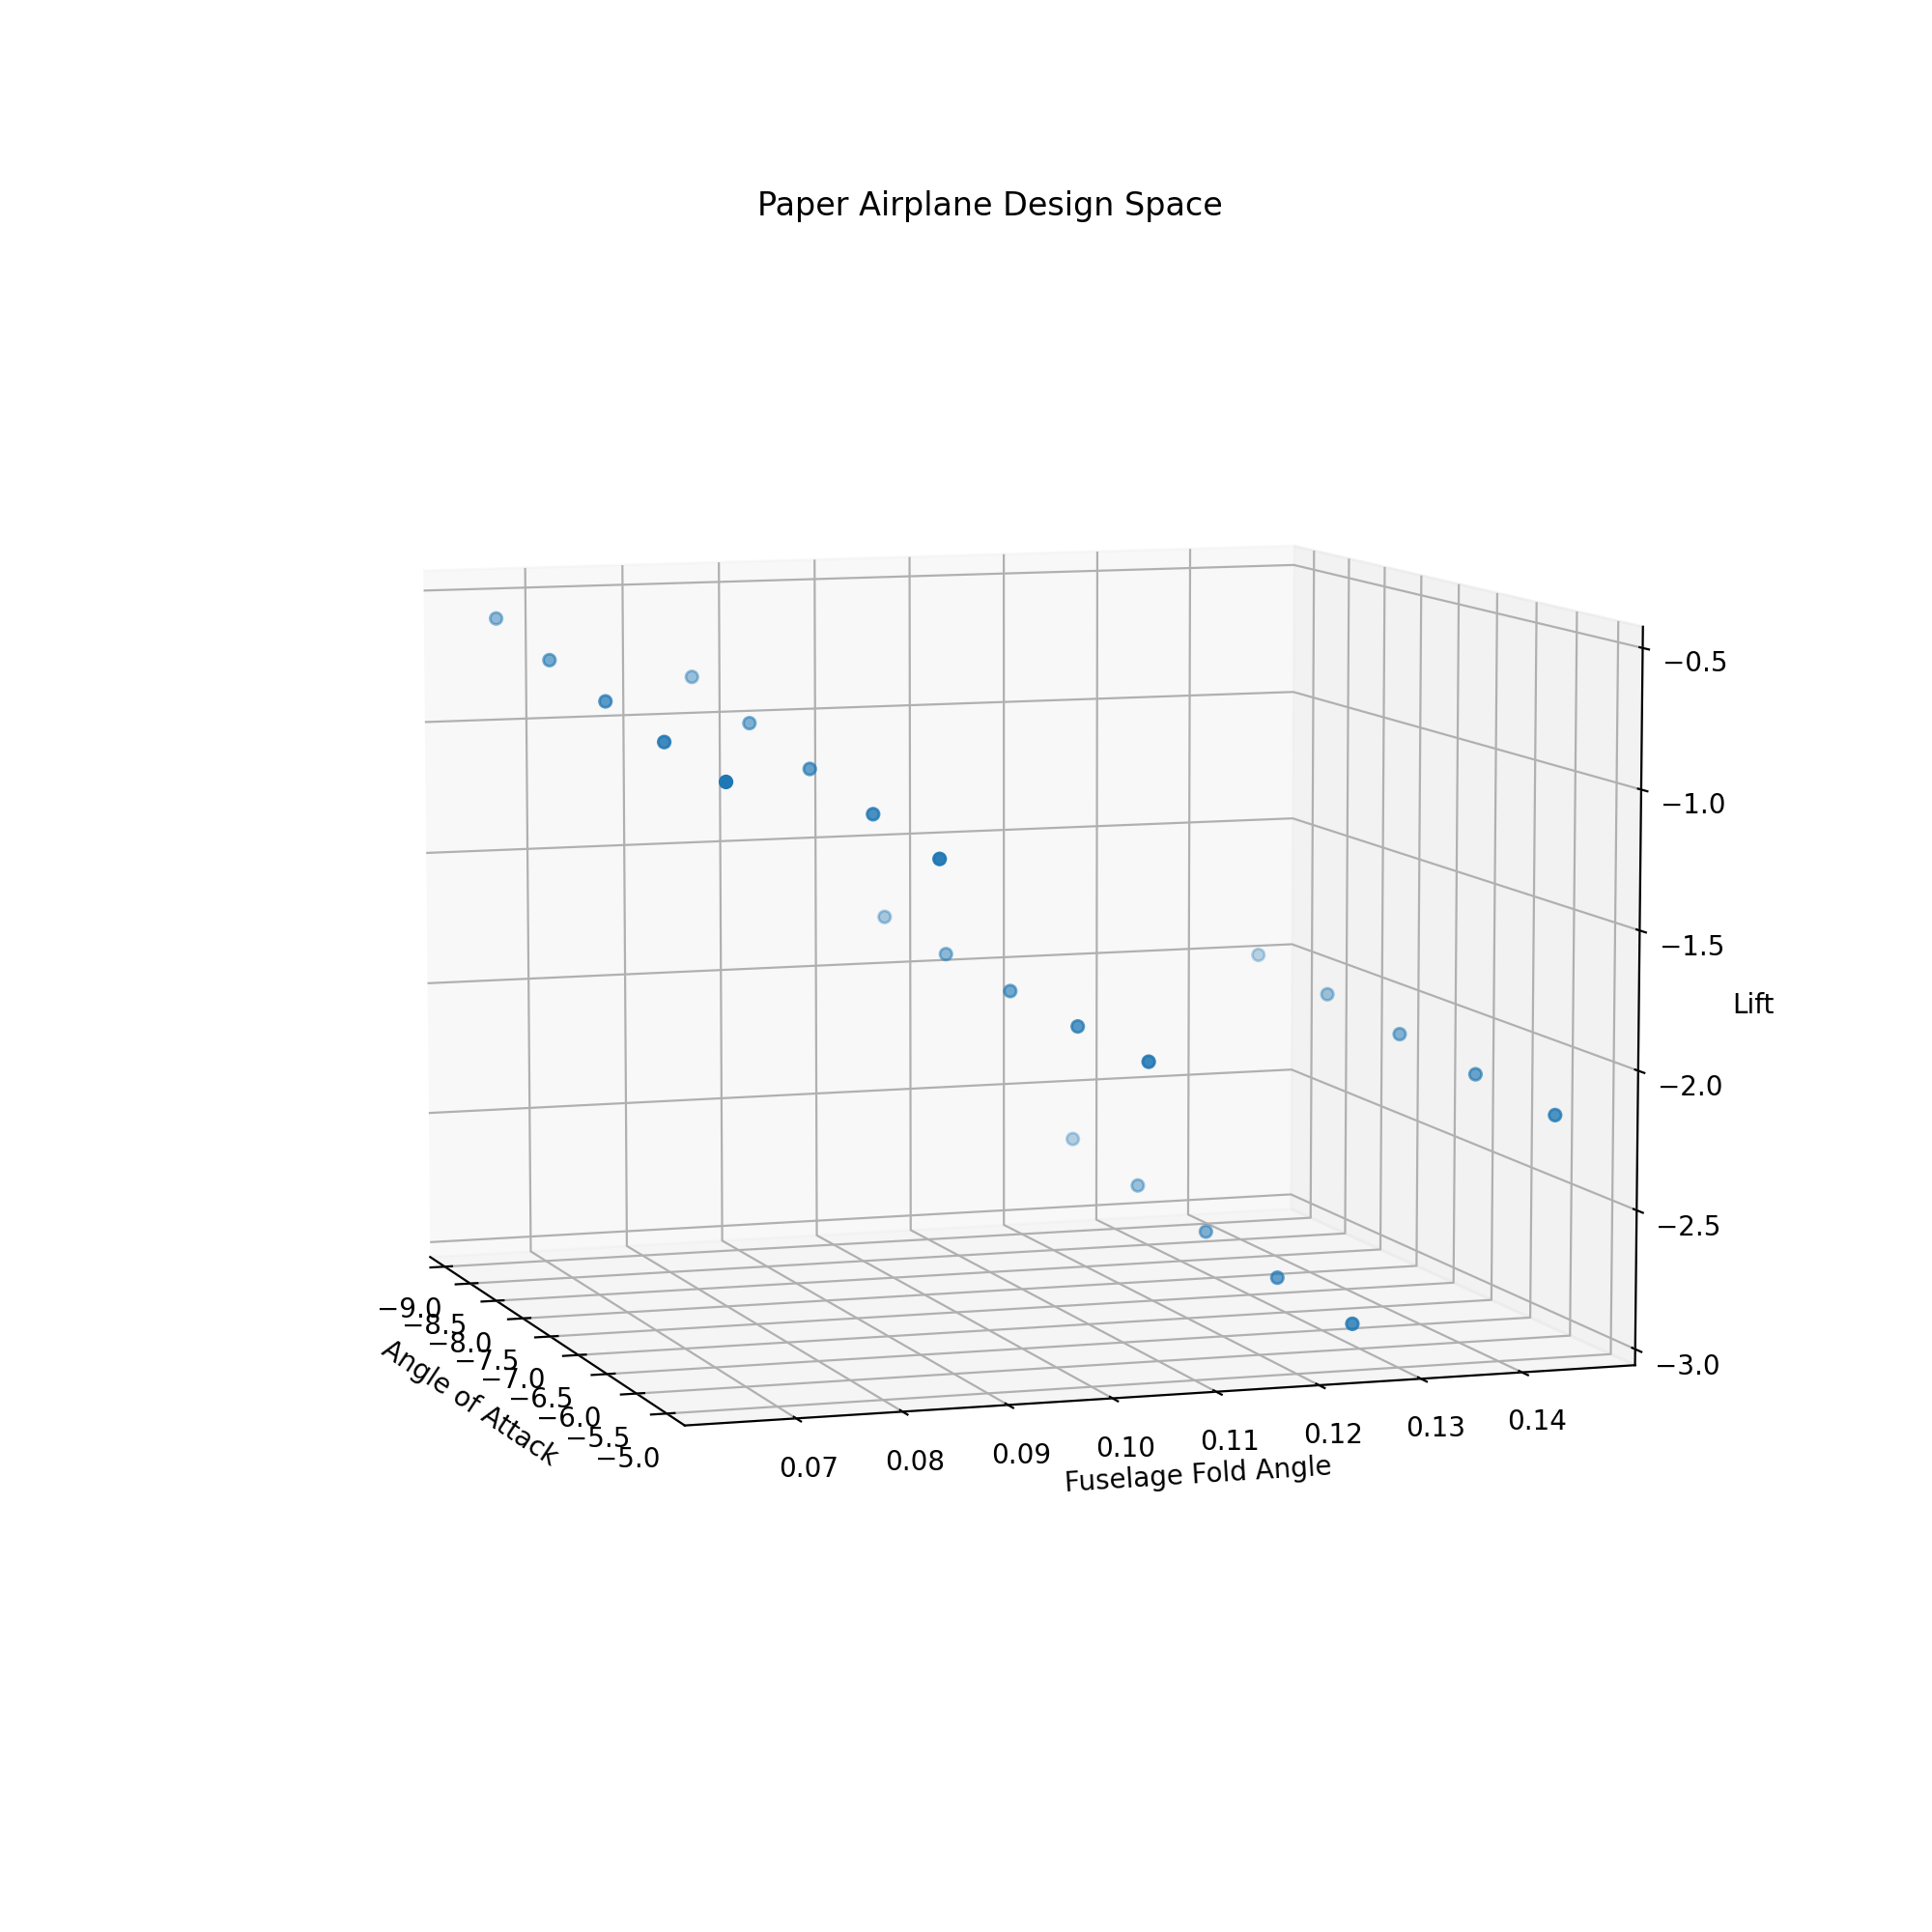

In [20]:
%matplotlib notebook
from mpl_toolkits import mplot3d
fig = plt.figure(figsize =(10, 10))
ax = plt.axes(projection ='3d')
 
# Creating plot
ax.scatter(df[['angle_of_attack']],df[['fuselage_rad']], df[['lift']])
ax.set_xlabel("Angle of Attack")
ax.set_ylabel("Fuselage Fold Angle")
ax.set_zlabel("Lift")
ax.set_title("Paper Airplane Design Space")
dir(ax)
plt.show()

In [ ]:
df

## Animate design "slice" in geometry space
it would be nice to move along various paths through this design space (eg, hold AoA and move the Fuselage Angle across an interesting range) and visualize the change in design and flow with a simple animation.

We'll define the slive of the DF we want, then extract the individual case outputs for them. We can generate the viz for each individually, then export them to frames in an animation.

This is weird because my Paraview python and my Jupyter/GMSH python aren't friends. So, we read a base script to do the viz we want, parametrize in any needed values from the DF, then write out a new python file ready to be run by 

In [21]:
def visualize_case(project_dir, case_name, base_vis_path="para.py"):
    
    base_vis = open(base_vis_path).read()
    #lame_name_hack:
    #proj, idx = case_name.split('_',1)
    #case_name = f"{proj}-{idx:0>3}"
    # interpolated_vis = base_vis.format(locals())
    # case_vis_path=path.join(project_dir, f"{case_name}-para.py")
    #with open(case_vis_path,'w') as f:
    #    f.write(interpolated_vis)
    pvpath = "/Applications/ParaView-5.11.0.app/Contents/bin/pvpython" # para.py fold-004
    print(f"Vis proc for {case_name}...")
    subprocess.run([pvpath, base_vis_path, f"{project_dir}/{case_name}"])
    return f"/Users/scot/Projects/{project_dir}/{case_name}-para.png"
    
vis_path = lambda x: visualize_case(x['project_dir'], x['case_name'])

def animate(project_name, file_paths, output_dir, framerate="2"):
    ffmpeg_path='/Users/scot/bin/ffmpeg'
    for i,file_path in enumerate(file_paths):
        shutil.copyfile(file_path, os.path.join(output_dir, f"animation_frame-{i:0>3}.png"))
    subprocess.run([ffmpeg_path, "-r", framerate,  "-y", "-i", 
                    f"/Users/scot/Projects/{project_name}/animation_frame-%03d.png", 
                    f"/Users/scot/Projects/{project_name}/{project_name}.gif"]) 
    #for i,file_path in enumerate(file_paths):
    #    os.remove(os.path.join(output_dir, f"animation_frame_{i}.png"))
    return f"/Users/scot/Projects/{project_name}/{project_name}.gif"

### run visualizations and set path to vis outputs

In [22]:
df['vis_path'] = df.apply(vis_path,axis=1)

Vis proc for f5-000...
para-processing f5/f5-000...


(   1.963s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fba4c81fc40): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-001...
para-processing f5/f5-001...


(   1.929s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fafa1f2c7c0): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-002...
para-processing f5/f5-002...


(   1.934s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fdc57f1ade0): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-003...
para-processing f5/f5-003...


(   1.964s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fce94f275d0): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-004...
para-processing f5/f5-004...


(   1.988s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f7ee3feb8d0): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-005...
para-processing f5/f5-005...


(   1.999s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fae137a9430): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-006...
para-processing f5/f5-006...


(   1.996s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fc05f8e74b0): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-007...
para-processing f5/f5-007...


(   1.932s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fd458f7ce30): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-008...
para-processing f5/f5-008...


(   1.869s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fecc3894f90): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-009...
para-processing f5/f5-009...


(   1.785s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7feb707b7750): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-010...
para-processing f5/f5-010...


(   1.792s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fc88d0e3020): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-011...
para-processing f5/f5-011...


(   1.783s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f9dd9f5b850): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-012...
para-processing f5/f5-012...


(   1.864s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f914f85f4d0): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-013...
para-processing f5/f5-013...


(   1.865s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f983cf6b610): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-014...
para-processing f5/f5-014...


(   1.884s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f934d711aa0): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-015...
para-processing f5/f5-015...


(   1.938s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f9a3186fc60): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-016...
para-processing f5/f5-016...


(   1.835s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7ff52f0cfb90): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-017...
para-processing f5/f5-017...


(   1.839s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7f7b9c893690): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-018...
para-processing f5/f5-018...


(   1.810s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fbef6728530): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-019...
para-processing f5/f5-019...


(   1.835s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fce8bf0dc50): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-020...
para-processing f5/f5-020...


(   1.855s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fb62074b820): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-021...
para-processing f5/f5-021...


(   1.806s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7ff1b5f532c0): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-022...
para-processing f5/f5-022...


(   1.785s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fd23cffb9a0): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-023...
para-processing f5/f5-023...


(   1.815s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fd97675a630): Refusing to enable OSPRay because it is not supported running in this configuration.


Vis proc for f5-024...
para-processing f5/f5-024...


(   1.788s) [paraview        ]    vtkPVRenderView.cxx:3273  WARN| vtkPVRenderView (0x7fde4d7ce190): Refusing to enable OSPRay because it is not supported running in this configuration.


In [13]:

animate('f4', list(df.loc[df['angle_of_attack']==3.0][['vis_path']]['vis_path']), output_dir='f4')

ffmpeg version N-112441-gc06d3d2404-tessus  https://evermeet.cx/ffmpeg/  Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 11.0.0 (clang-1100.0.33.17)
  configuration: --cc=/usr/bin/clang --prefix=/opt/ffmpeg --extra-version=tessus --enable-avisynth --enable-fontconfig --enable-gpl --enable-libaom --enable-libass --enable-libbluray --enable-libdav1d --enable-libfreetype --enable-libgsm --enable-libmodplug --enable-libmp3lame --enable-libmysofa --enable-libopencore-amrnb --enable-libopencore-amrwb --enable-libopenh264 --enable-libopenjpeg --enable-libopus --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvmaf --enable-libvo-amrwbenc --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxavs --enable-libxml2 --enable-libxvid --enable-libzimg --enable-libzmq --enable-libzvbi --enable-version3 --pkg-conf

'/Users/scot/Projects/f4/f4.gif'

In [ ]:
visualize_case('f2', 'f2_3')

In [ ]:
ffmpeg_path='/Users/scot/bin/ffmpeg'
subprocess.run([ffmpeg_path, "-r", "6", "-i", 
                f"/Users/scot/Projects/{project_name}/{project_name}-%03d.jpg", 
                f"/Users/scot/Projects/{project_name}{project_name}.gif"]) 

### Make exploratory (unmeshed) animation of models

In [ ]:
df['geometry'] = run_confs(conf_list, False, False)

### Generate meshes
would be nice to leave the animation alone...

In [ ]:
for i in range(len(conf_list)):
    case_name=f"{project_name}-{i:0>3}"
    create_sim(case_name, meshing=True, 
                gifpath=f"{project_name}_meshed-{i:0>3}.jpg", 
                meshpath=f"{case_name}.su2",
                popup=False, meshsize_large=2.0,
                **conf_list[i])
    #subprocess.run(["/Users/scot/Projects/SU2/bin/SU2_CFD", f"{case_name}.cfg"]) 
ffmpeg_path='/Users/scot/bin/ffmpeg'
subprocess.run([ffmpeg_path, "-i", f"/Users/scot/Projects/{project_name}_meshed-%03d.jpg", f"{project_name}_meshed.gif"]) 

## Actually run cases!

In [ ]:
for i in range(len(conf_list)):
    case_name=f"{project_name}-{i:0>3}"
    create_sim(case_name, meshing=True, 
                gifpath=None, #f"{project_name}-{i:0>3}.jpg", 
                meshpath=f"{case_name}.su2",
                popup=False, meshsize_large=4.0,
                **conf_list[i])
    subprocess.run(["/Users/scot/Projects/SU2/bin/SU2_CFD", f"{case_name}.cfg"]) 
#ffmpeg_path='/Users/scot/bin/ffmpeg'
#subprocess.run([ffmpeg_path, "-i", f"/Users/scot/Projects/{project_name}-%03d.jpg", f"{project_name}_meshed.gif"]) 

In [ ]:
import subprocess
        # subprocess.call("ffmpeg -i t8-%d.jpg t8.mpg".split(' '))
# /Users/scot/bin/ffmpeg -i /Users/scot/Projects/pplane-%03d.jpg test.gif
ffmpeg_path='/Users/scot/bin/ffmpeg'
subprocess.run([ffmpeg_path, "-i", f"/Users/scot/Projects/{project_name}-%03d.jpg", f"{project_name}.gif"]) 

### Superlight config formatting

In [ ]:
base_config_path='base.cfg'
config_path=f"{project_name}.cfg"
project_config=open(base_config_path).read().format(**globals())
with open(config_path,'w') as f:
    f.write(project_config)
#base_config

## Run subprocess
* Used to need this for `gmsh` file translation, but no longer.
* Now is this just to run SU2? Fine, but likely replaceable with a direct SU2 API....

In [ ]:
import subprocess

subprocess.run(["/Users/scot/Projects/SU2/bin/SU2_CFD", config_path]) 

## Read field output from Simulation run

In [ ]:
import pandas
for i in range(10):
    sdf=pandas.read_csv(f"fold-{i:0>3}-surface_flow.csv")
    print(f"{conf_list[i]['fuselage_rad']}: {df[['Momentum_y']].sum()} {df[['Momentum_x']].sum()}")

In [ ]:
sys.path.append('/Applications/ParaView-5.11.0.app/Contents/Python/')
import paraview.simple
# '/Applications/ParaView-5.11.0.app/Contents/Python/

In [ ]:
ffmpeg_path='/Users/scot/bin/ffmpeg'
subprocess.run([ffmpeg_path, "-r", "6", "-i", f"/Users/scot/Projects/{project_name}-%03d-para.png", f"{project_name}-para.gif"]) 